In [2]:
import numpy as np
from numpy.ma import masked_values as maval
import gsw
import xarray as xr
import pandas as pd
import os.path as op
from datetime import datetime, timedelta
from scipy.interpolate import PchipInterpolator as pchip
from scipy.signal import medfilt
import dask.array as dsar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm
import matplotlib.colors as clr
import matplotlib.ticker as tick
import matplotlib.path as mpath
import matplotlib.pyplot as plt

%matplotlib inline

In [24]:
import cmocean as cmocean
import os

Float numbers for SOCCOM floats dropped off I06S
12878	5906033	5906033	325020190403	I06S	14	1	20190418	1503	-65.499420	30.000760	20190419	0001	-65.5033	29.9567	Apex	IONpF
12882	5906032	5906032	325020190403	I06S	uwDrop	-	-	-	-	-	20190506	0153	-44.9583	29.0883	Apex	IONpF
12885	5906031	5906031	325020190403	I06S	33	1	20190424	1853	-55.999800	30.002800	20190425	0519	-55.8717	29.9400	Apex	IONpF
12888	5906030	5906030	325020190403	I06S	42	1	20190430	0816	-51.499940	30.001580	20190430	1854	-51.3550	30.2083	Apex	IONpF
12892	5906034	5906034	325020190403	I06S	19	1	20190419	2333	-63.000360	29.999700	20190420	0950	-63.0267	29.9967	Apex	IONpF


Identified from SOCCOM float viz: https://www.mbari.org/science/upper-ocean-systems/chemical-sensor-group/soccom-float-visualization/
12880 (dropped off ANDREXII), 12882, 12885, 12888, 9657(floated into the region)

The others dopped during the same cruise are either too far south under the ice, or too far north. 

In [10]:
SOCCOM_flt_ids = [12880, 12882, 12885, 12888]
# there is also 9657 but it entered the region an year earlier almost.

In [11]:
# Load Float Data
HRdir = "/Users/dhruvbalwada/work_root/sogos/data/raw/SOCCOM/manual_download/SOCCOM_HRQC_LIAR_netcdf_20191027/"
LRdir = "/Users/dhruvbalwada/work_root/sogos/data/raw/SOCCOM/manual_download/SOCCOM_LRQC_LIAR_netcdf_20191006/"


float_dic_HR = {}
float_dic_LR = {}

for i in SOCCOM_flt_ids:
    float_dic_HR[i] = xr.open_dataset(HRdir + str(i) + "SOOCN_HRQC.nc")
    float_dic_LR[i] = xr.open_dataset(LRdir + str(i) + "SOOCNQC.nc")

In [22]:
# Load topography
topo = xr.open_dataarray(
    "/Users/dhruvbalwada/work_root/sogos/data/processed/ETOPO1_Ice_g_gmt4_coarsened5.nc"
)

In [21]:
# Load fronts

pf = pd.read_csv(
    op.join("/Users/dhruvbalwada/work_root/sogos/data/processed/fronts/pf.txt"),
    delim_whitespace=True,
    header=None,
    dtype=float,
    names=["lon", "lat"],
)
saf = pd.read_csv(
    op.join("/Users/dhruvbalwada/work_root/sogos/data/processed/fronts/saf.txt"),
    delim_whitespace=True,
    header=None,
    dtype=float,
    names=["lon", "lat"],
)
sbdy = pd.read_csv(
    op.join("/Users/dhruvbalwada/work_root/sogos/data/processed/fronts/sbdy.txt"),
    delim_whitespace=True,
    nrows=1079,
    header=None,
    dtype=float,
    names=["lon", "lat"],
)

In [25]:
# Load Cruise

data_folder = "/Users/dhruvbalwada/work_root/sogos/data/raw/cruise/325020190403_nc_ctd/"
file_names = sorted(os.listdir(data_folder))

cruise_dic = {}
for count, fil in enumerate(file_names):
    cruise_dic[count] = xr.open_dataset(data_folder + fil)

lat = [cruise_dic[key].latitude.values[0] for key in cruise_dic.keys()]
lon = [cruise_dic[key].longitude.values[0] for key in cruise_dic.keys()]
time = [cruise_dic[key].time.values[0] for key in cruise_dic.keys()]
max_pres = [cruise_dic[key].pressure.max().values for key in cruise_dic.keys()]
len_pres = [len(cruise_dic[key].pressure) for key in cruise_dic.keys()]

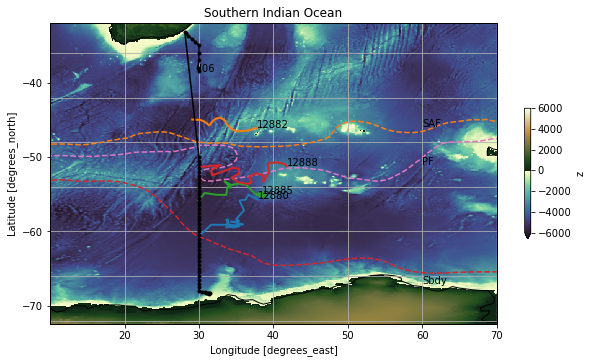

In [63]:
plt.figure(figsize=(10, 6))

ax = plt.subplot(
    111, projection=ccrs.PlateCarree()
)  # create a set of axes with Mercator projection
ax.set_xticks([20, 30, 40, 50, 60, 70], crs=ccrs.PlateCarree())
ax.set_yticks([-70, -60, -50, -40], crs=ccrs.PlateCarree())
ax.set_extent([10, 70, -70, -32])
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)  # plot some data on them

topo.sel(y=slice(-90, -30)).sel(x=slice(10, 70)).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"shrink": 0.4},
    vmin=-6000,
    cmap=cmocean.cm.topo,
)

plt.plot(saf.lon, saf.lat, transform=ccrs.PlateCarree(), linestyle="--", color="C1")
plt.text(60, -46, "SAF")
plt.plot(pf.lon, pf.lat, transform=ccrs.PlateCarree(), linestyle="--", color="C6")
plt.text(60, -51, "PF")
# plt.plot(saccf.lon, saccf.lat, transform=ccrs.PlateCarree())
plt.plot(sbdy.lon, sbdy.lat, transform=ccrs.PlateCarree(), linestyle="--", color="C3")
plt.text(60, -67, "Sbdy")

for i in [12880, 12882, 12885, 12888]:
    ax.plot(
        float_dic_HR[i].Lon.values,
        float_dic_HR[i].Lat.values,
        "-",
        rasterized=True,
        linewidth=2,
    )
    ax.text(float_dic_HR[i].Lon.values[-1], float_dic_HR[i].Lat.values[-1], str(i))

ax.plot(lon, lat, transform=ccrs.PlateCarree(), Marker=".", color="k")
ax.text(lon[-1], lat[-1], "I06")

ax.gridlines()
ax.set_title("Southern Indian Ocean")  # label it

plt.savefig("../figures/region_plot.png")

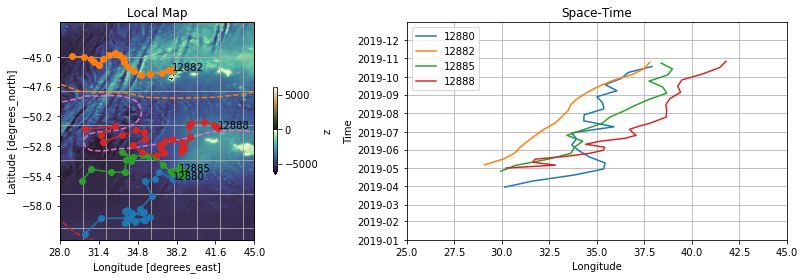

In [86]:
plt.figure(figsize=(15, 4))
plt.tight_layout()
ax = plt.subplot(
    121, projection=ccrs.PlateCarree()
)  # create a set of axes with Mercator projection
ax.set_xticks(np.linspace(28, 45, 6), crs=ccrs.PlateCarree())
ax.set_yticks(np.linspace(-58.0, -45, 6), crs=ccrs.PlateCarree())
ax.set_extent([28, 45, -61, -42])
ax.add_feature(cfeature.COASTLINE)  # plot some data on them
# ax.plot(ds.Lon.values, ds.Lat.values)
# ax.scatter(ds_HR.Lon.values, ds_HR.Lat.values,
#           s=25., c=ds_HR.groupby('JULD').mean().JULD.values,
#               rasterized=True)
topo.sel(y=slice(-65, -40)).sel(x=slice(25, 50)).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"shrink": 0.4},
    vmin=-6000,
    cmap=cmocean.cm.topo,
)

plt.plot(saf.lon, saf.lat, transform=ccrs.PlateCarree(), linestyle="--", color="C1")
plt.plot(pf.lon, pf.lat, transform=ccrs.PlateCarree(), linestyle="--", color="C6")
# plt.plot(saccf.lon, saccf.lat, transform=ccrs.PlateCarree())
plt.plot(sbdy.lon, sbdy.lat, transform=ccrs.PlateCarree(), linestyle="--", color="C3")


for i in [12880, 12882, 12885, 12888]:
    ax.plot(
        float_dic_HR[i].Lon.values, float_dic_HR[i].Lat.values, "o-", rasterized=True
    )
    ax.text(float_dic_HR[i].Lon.values[-1], float_dic_HR[i].Lat.values[-1], str(i))
ax.gridlines()
ax.set_title("Local Map")  # label it

ax = plt.subplot(122)

for i in float_dic_HR.keys():
    plt.plot(float_dic_HR[i].Lon, float_dic_HR[i].JULD, label=i)

    n += 1
plt.ylim([np.datetime64("2019-01-01"), np.datetime64("2019-12-31")])
plt.xlim([25, 45])
plt.xlabel("Longitude")
plt.ylabel("Time")
plt.title("Space-Time")
plt.grid()
plt.legend()

plt.savefig("../figures/local_map.png")

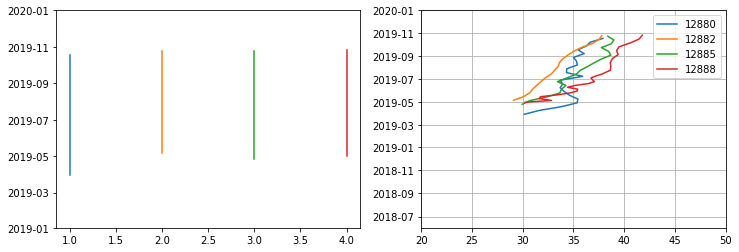

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
n = 1
for i in float_dic_HR.keys():
    plt.plot(n * np.ones(len(float_dic_HR[i].JULD)), float_dic_HR[i].JULD)
    n += 1
plt.ylim([np.datetime64("2019-01-01"), np.datetime64("2020-01-01")])

plt.subplot(122)

for i in float_dic_HR.keys():
    plt.plot(float_dic_HR[i].Lon, float_dic_HR[i].JULD, label=i)
    n += 1
plt.ylim([np.datetime64("2018-06-01"), np.datetime64("2020-01-01")])
plt.xlim([20, 50])
plt.grid()
plt.legend()

### 12888 
This is the float that was released with the gliders

In [95]:
ds_flt = float_dic_HR[12888]
ds_flt

<xarray.Dataset>
Dimensions:              (NPARAMETER: 46, N_LEVELS: 558, N_PROF: 26, distance: 26)
Coordinates:
  * distance             (distance) float64 0.0 1.834e+05 ... 1.808e+06 1.85e+06
Dimensions without coordinates: NPARAMETER, N_LEVELS, N_PROF
Data variables:
    Cruise               |S11 ...
    Station              (N_PROF) int32 ...
    Lon                  (N_PROF) float64 30.23 32.83 31.63 ... 41.45 41.79
    Lat                  (N_PROF) float64 -51.34 -51.07 -51.8 ... -50.93 -51.24
    Lat_QF               (N_PROF) |S1 ...
    Lat_QFA              (N_PROF) float64 ...
    Pressure             (N_PROF, N_LEVELS) float64 ...
    Pressure_QF          (N_PROF, N_LEVELS) |S1 ...
    Pressure_QFA         (N_PROF, N_LEVELS) float64 ...
    Temperature          (N_PROF, N_LEVELS) float64 ...
    Temperature_QF       (N_PROF, N_LEVELS) |S1 ...
    Temperature_QFA      (N_PROF, N_LEVELS) float64 ...
    Salinity             (N_PROF, N_LEVELS) float64 ...
    Salinity_QF        

In [131]:
dist = gsw.distance(ds_flt.Lon, ds_flt.Lat)
distance = np.cumsum(dist)
distance = np.insert(distance, 0, 0)
ds_flt["distance"] = distance

In [132]:
# Calculate density and spice

## Add density and other things
SA = xr.apply_ufunc(
    gsw.SA_from_SP,
    ds_flt.Salinity,
    ds_flt.Pressure,
    ds_flt.Lon,
    ds_flt.Lat,
    dask="parallelized",
    output_dtypes=[float],
).rename("SA")
CT = xr.apply_ufunc(
    gsw.CT_from_t,
    SA,
    ds_flt.Temperature,
    ds_flt.Pressure,
    dask="parallelized",
    output_dtypes=[float],
).rename("CT")
SIGMA0 = xr.apply_ufunc(
    gsw.sigma0, SA, CT, dask="parallelized", output_dtypes=[float]
).rename("SIGMA0")
SPICE = xr.apply_ufunc(
    gsw.spiciness0, SA, CT, dask="parallelized", output_dtypes=[float]
).rename("SPICE")

ds_flt = xr.merge([ds_flt, SIGMA0, SPICE, SA, CT])

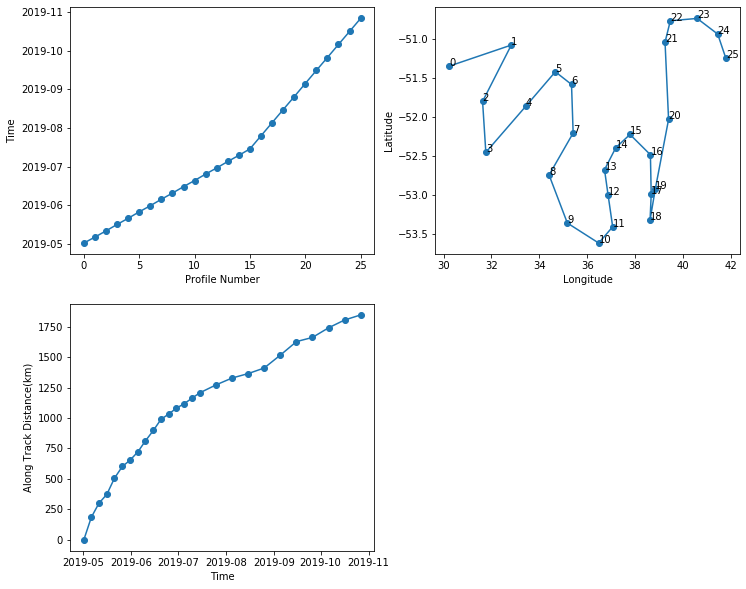

In [100]:
# Sampling

plt.figure(figsize=(12, 10))

plt.subplot(221)
ds_flt.JULD.plot(Marker="o")
plt.ylabel("Time")
plt.xlabel("Profile Number")
# the faster sampling is visible for the first 15 profiles.

plt.subplot(222)
plt.plot(ds_flt.Lon, ds_flt.Lat, Marker="o")
for i in range(len(ds_flt.Lon)):
    plt.text(ds_flt.Lon[i], ds_flt.Lat[i], str(i))
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.subplot(223)
plt.plot(ds_flt.JULD, ds_flt.distance / 1e3, Marker="o")
plt.xlabel("Time")
plt.ylabel("Along Track Distance(km)")

plt.savefig("../figures/12888_basic.png")

### Raw data

In [93]:
Numgrid = np.tile(ds_flt.N_PROF, (558, 1))
Numgrid.shape

(558, 26)

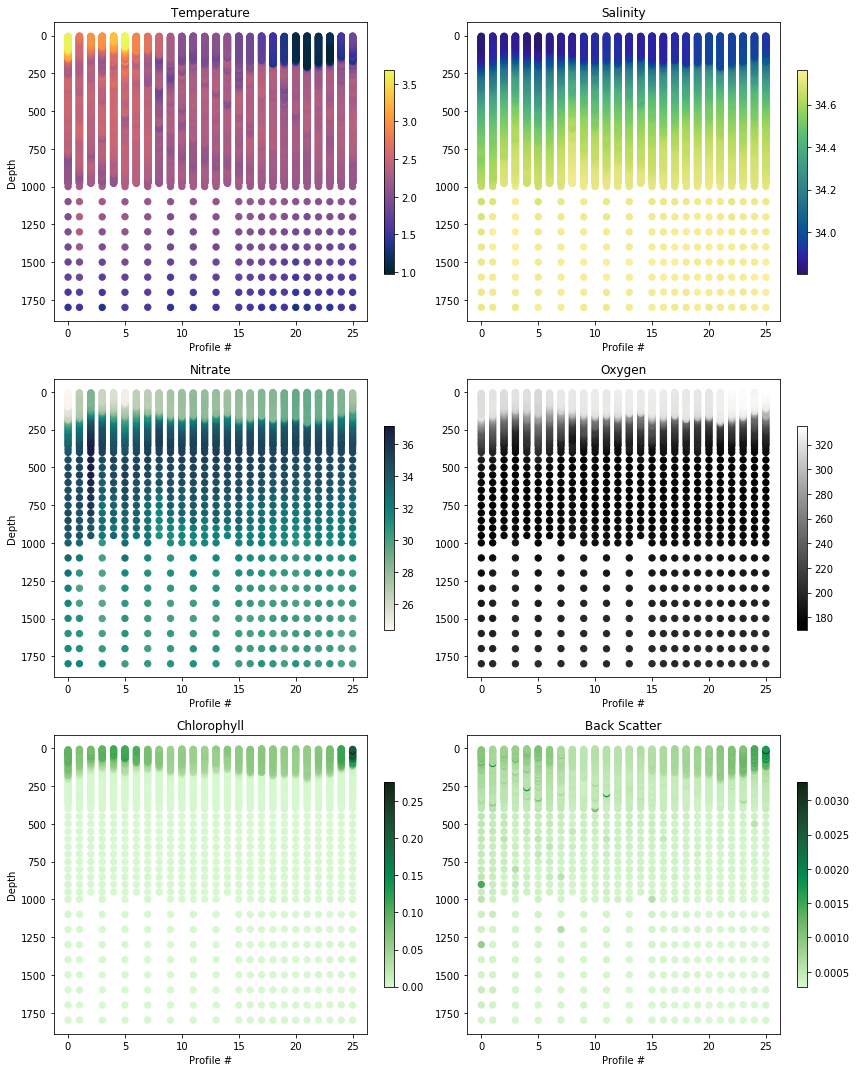

In [116]:
# raw plots : T,S, Oxygen, Nitrate, Chl_a, backscatter (b_bp700), POC, phinsitu, ph25c, TALK, DIC, pCO2
plt.figure(figsize=(12, 15))

plt.subplot(321)
plt.scatter(
    Numgrid.T, ds_flt.Pressure, s=40, c=ds_flt.Temperature, cmap=cmocean.cm.thermal
)
plt.colorbar(orientation="vertical", fraction=0.03)
plt.gca().invert_yaxis()
plt.xlabel("Profile #")
plt.ylabel("Depth")
plt.title("Temperature")

plt.subplot(322)
plt.scatter(Numgrid.T, ds_flt.Pressure, s=40, c=ds_flt.Salinity, cmap=cmocean.cm.haline)
plt.colorbar(orientation="vertical", fraction=0.03)
plt.gca().invert_yaxis()
plt.xlabel("Profile #")
plt.title("Salinity")

plt.subplot(323)
plt.scatter(Numgrid.T, ds_flt.Pressure, s=40, c=ds_flt.Nitrate, cmap=cmocean.cm.tempo)
plt.colorbar(orientation="vertical", fraction=0.03)
plt.gca().invert_yaxis()
plt.xlabel("Profile #")
plt.ylabel("Depth")
plt.title("Nitrate")

plt.subplot(324)
plt.scatter(Numgrid.T, ds_flt.Pressure, s=40, c=ds_flt.Oxygen, cmap=cmocean.cm.gray)
plt.colorbar(orientation="vertical", fraction=0.03)
plt.gca().invert_yaxis()
plt.xlabel("Profile #")
# plt.ylabel('Depth')
plt.title("Oxygen")

plt.subplot(325)
plt.scatter(
    Numgrid.T, ds_flt.Pressure, s=40, c=ds_flt.Chl_a_corr, cmap=cmocean.cm.algae
)
plt.colorbar(orientation="vertical", fraction=0.03)
plt.gca().invert_yaxis()
plt.xlabel("Profile #")
plt.ylabel("Depth")
plt.title("Chlorophyll")

plt.subplot(326)
plt.scatter(Numgrid.T, ds_flt.Pressure, s=40, c=ds_flt.b_bp700, cmap=cmocean.cm.algae)
plt.colorbar(orientation="vertical", fraction=0.03)
plt.gca().invert_yaxis()
plt.xlabel("Profile #")
# plt.ylabel('Depth')
plt.title("Back Scatter")

plt.tight_layout()

plt.savefig("../figures/12888_raw_props1.png")

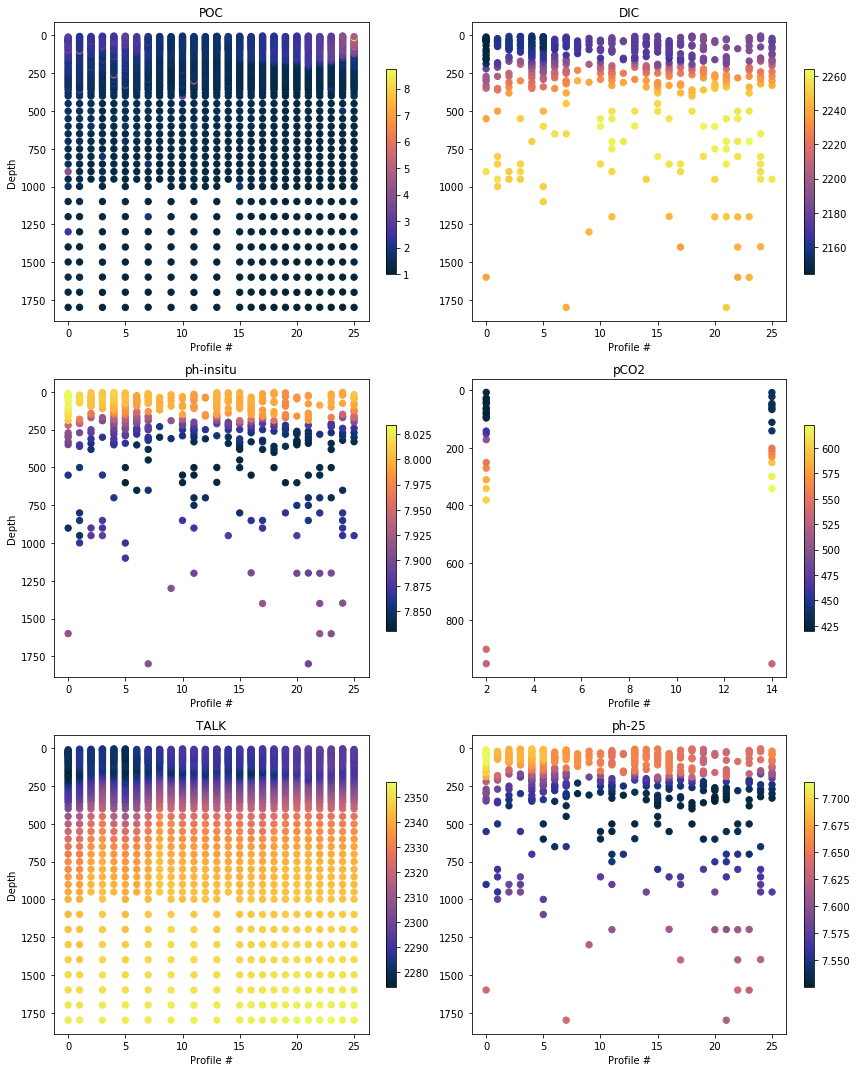

In [126]:
# raw plots :  POC, phinsitu, ph25c, TALK, DIC, pCO2
plt.figure(figsize=(12, 15))

plt.subplot(321)
plt.scatter(Numgrid.T, ds_flt.Pressure, s=40, c=ds_flt.POC, cmap=cmocean.cm.thermal)
plt.colorbar(orientation="vertical", fraction=0.03)
plt.gca().invert_yaxis()
plt.xlabel("Profile #")
plt.ylabel("Depth")
plt.title("POC")

plt.subplot(322)
plt.scatter(
    Numgrid.T, ds_flt.Pressure, s=40, c=ds_flt.DIC_LIAR, cmap=cmocean.cm.thermal
)
plt.colorbar(orientation="vertical", fraction=0.03)
plt.gca().invert_yaxis()
plt.xlabel("Profile #")
plt.title("DIC")

plt.subplot(323)
plt.scatter(
    Numgrid.T, ds_flt.Pressure, s=40, c=ds_flt.pHinsitu, cmap=cmocean.cm.thermal
)
plt.colorbar(orientation="vertical", fraction=0.03)
plt.gca().invert_yaxis()
plt.xlabel("Profile #")
plt.ylabel("Depth")
plt.title("ph-insitu")

plt.subplot(324)
plt.scatter(
    Numgrid.T, ds_flt.Pressure, s=40, c=ds_flt.pCO2_LIAR, cmap=cmocean.cm.thermal
)
plt.colorbar(orientation="vertical", fraction=0.03)
plt.gca().invert_yaxis()
plt.xlabel("Profile #")
# plt.ylabel('Depth')
plt.title("pCO2")

plt.subplot(325)
plt.scatter(
    Numgrid.T, ds_flt.Pressure, s=40, c=ds_flt.TALK_LIAR, cmap=cmocean.cm.thermal
)
plt.colorbar(orientation="vertical", fraction=0.03)
plt.gca().invert_yaxis()
plt.xlabel("Profile #")
plt.ylabel("Depth")
plt.title("TALK")

plt.subplot(326)
plt.scatter(Numgrid.T, ds_flt.Pressure, s=40, c=ds_flt.pH25C, cmap=cmocean.cm.thermal)
plt.colorbar(orientation="vertical", fraction=0.03)
plt.gca().invert_yaxis()
plt.xlabel("Profile #")
# plt.ylabel('Depth')
plt.title("ph-25")

plt.tight_layout()

plt.savefig("../figures/12888_raw_props2.png")

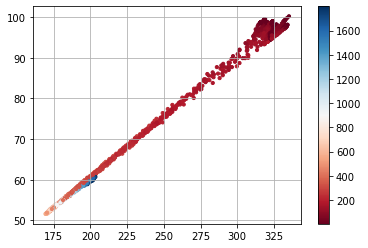

In [127]:
plt.scatter(ds_flt.Oxygen, ds_flt.OxygenSat, s=10, c=ds_flt.Pressure, cmap="RdBu")
plt.grid()
plt.colorbar()

In [128]:
# make a gridded density (Sigma0) for  plotting on TS plots
Tpts = np.linspace(0.8, 3.8, 40)
Spts = np.linspace(33.75, 35, 41)
[Tg, Sg] = np.meshgrid(Tpts, Spts)
rhoTS = gsw.sigma0(Sg, Tg)

In [129]:
ncasts = len(ds_flt.N_PROF)
ncasts

26

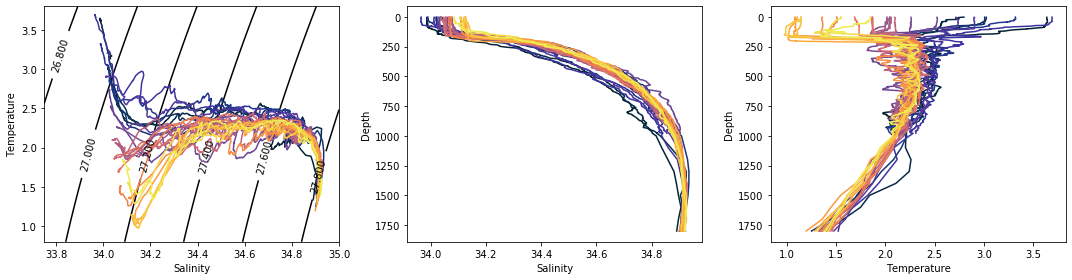

In [136]:
plt.figure(figsize=(15, 4))

plt.subplot(131)
CS = plt.contour(Sg, Tg, rhoTS, levels=7, colors="k")
plt.clabel(CS)
for i in range(ncasts):
    plt.plot(
        ds_flt.isel(N_PROF=i).SA.T,
        ds_flt.CT.isel(N_PROF=i).T,
        color=cmocean.cm.thermal(i / ncasts),
    )
plt.xlim([33.75, 35])
plt.ylim([0.8, 3.8])
plt.xlabel("Salinity")
plt.ylabel("Temperature")

plt.subplot(132)
for i in range(ncasts):
    plt.plot(
        ds_flt.SA.isel(N_PROF=i),
        ds_flt.Pressure.isel(N_PROF=i),
        color=cmocean.cm.thermal(i / ncasts),
    )
plt.gca().invert_yaxis()
plt.xlabel("Salinity")
plt.ylabel("Depth")

plt.subplot(133)
for i in range(ncasts):
    plt.plot(
        ds_flt.CT.isel(N_PROF=i),
        ds_flt.Pressure.isel(N_PROF=i),
        color=cmocean.cm.thermal(i / ncasts),
    )
plt.gca().invert_yaxis()
plt.xlabel("Temperature")
plt.ylabel("Depth")

plt.tight_layout()
plt.savefig("../figures/TS.png")

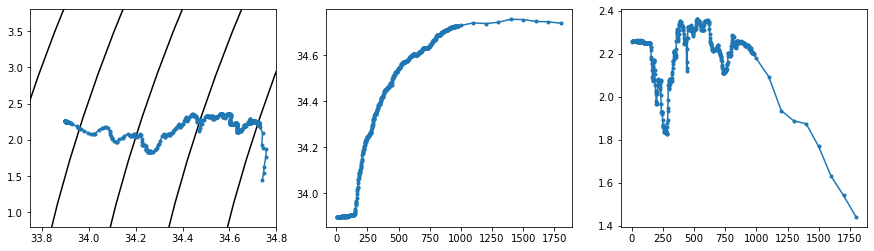

In [76]:
n = 9

plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.contour(Sg, Tg, rhoTS, levels=30, colors="k")
plt.plot(ds_flt.Salinity.isel(N_PROF=n), ds_flt.Temperature.isel(N_PROF=n), Marker=".")
plt.xlim([33.75, 34.8])
plt.ylim([0.8, 3.8])

plt.subplot(132)
plt.plot(ds_flt.Pressure.isel(N_PROF=n), ds_flt.Salinity.isel(N_PROF=n), Marker=".")

plt.subplot(133)
plt.plot(ds_flt.Pressure.isel(N_PROF=n), ds_flt.Temperature.isel(N_PROF=n), Marker=".")

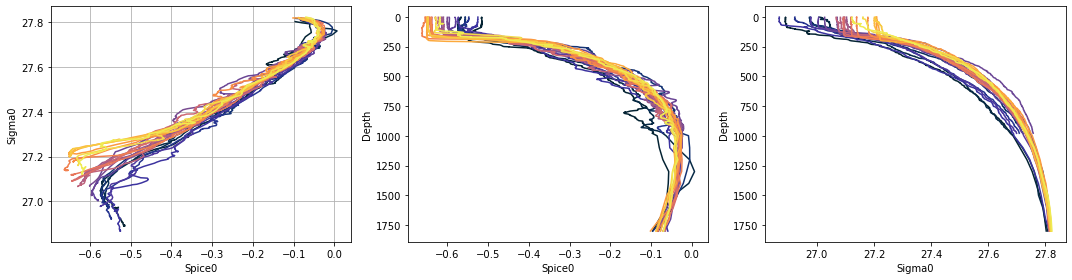

In [286]:
plt.figure(figsize=(15, 4))

plt.subplot(131)
# plt.contour(Sg, Tg, rhoTS, levels=30, colors="k")
for i in range(ncasts):
    plt.plot(
        ds_flt.isel(N_PROF=i).SPICE,
        ds_flt.SIGMA0.isel(N_PROF=i),
        color=cmocean.cm.thermal(i / ncasts),
    )
plt.grid()
plt.xlabel('Spice0')
plt.ylabel('Sigma0')

plt.subplot(132)
for i in range(ncasts):
    plt.plot(
        ds_flt.SPICE.isel(N_PROF=i),
        ds_flt.Pressure.isel(N_PROF=i),
        color=cmocean.cm.thermal(i / ncasts),
    )
plt.gca().invert_yaxis()
plt.xlabel('Spice0')
plt.ylabel('Depth')

plt.subplot(133)
for i in range(ncasts):
    plt.plot(
        ds_flt.SIGMA0.isel(N_PROF=i),
        ds_flt.Pressure.isel(N_PROF=i),
        color=cmocean.cm.thermal(i / ncasts),
    )
plt.gca().invert_yaxis()
plt.xlabel('Sigma0')
plt.ylabel('Depth')
plt.tight_layout()
plt.savefig("../figures/density_spice.png")

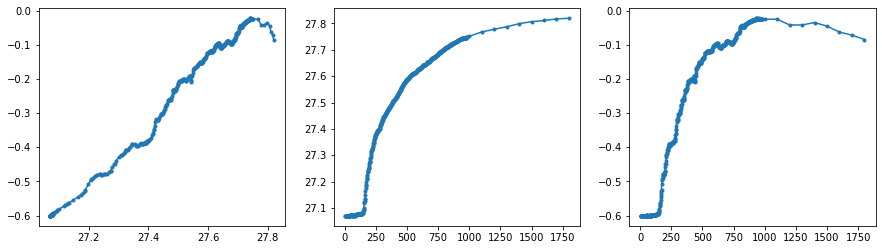

In [95]:
n = 9

plt.figure(figsize=(15, 4))

plt.subplot(131)
# plt.contour(Sg, Tg, rhoTS, levels=30, colors="k")
plt.plot(ds_flt.SIGMA0.isel(N_PROF=n), ds_flt.SPICE.isel(N_PROF=n), Marker=".")
# plt.xlim([33.75, 34.8])
# plt.ylim([0.8, 3.8])

plt.subplot(132)
plt.plot(ds_flt.Pressure.isel(N_PROF=n), ds_flt.SIGMA0.isel(N_PROF=n), Marker=".")

plt.subplot(133)
plt.plot(ds_flt.Pressure.isel(N_PROF=n), ds_flt.SPICE.isel(N_PROF=n), Marker=".")

### N2 and mixed layer depths

To estimate the N2 we will need to put the data on a constant dp grid, or else there are spikes in N2 profile.

In [172]:
from scipy.interpolate import PchipInterpolator
# using pchip interpolator because it supposed to be the best! 

In [239]:
def pchip_interp(y, pres, pint):
    pres_temp = -pres[(np.isfinite(pres) & np.isfinite(y))]
    y = y[(np.isfinite(pres) & np.isfinite(y))]

    [pres_unique, unique_ids] = np.unique(pres_temp, return_index=True)

    y = y[unique_ids]

    f = PchipInterpolator(pres_unique, y, extrapolate=False)

    return f(-pint)

In [340]:
Paxis = np.linspace(0, 2000, 1001)

In [355]:
dens_int = np.zeros((len(ds_flt.N_PROF), len(Paxis)))

In [356]:
for i in range(len(ds_flt.N_PROF)):
    dens_int[i, :] = pchip_interp(ds_flt.SIGMA0.isel(N_PROF=i).values,
        ds_flt.Pressure.isel(N_PROF=i).values,Paxis)
dens_int = xr.DataArray(dens_int, coords=[ds_flt.N_PROF, Paxis], dims=['N_PROF', 'Pressure']).rename('SIGMA0')
ds_flt_int = dens_int.to_dataset()    

In [424]:
vars_to_int = ['Temperature', 'Salinity', 'Oxygen', 'OxygenSat', 'Nitrate', 'Chl_a', 
               'Chl_a_corr', 'b_bp700', 'POC', 'pHinsitu', 'TALK_LIAR', 'DIC_LIAR']

In [429]:
temp_int = np.zeros((len(ds_flt.N_PROF), len(Paxis)))
for var in vars_to_int: 
    for i in range(len(ds_flt.N_PROF)):
        temp_int[i, :] = pchip_interp(ds_flt[var].isel(N_PROF=i).values,
            ds_flt.Pressure.isel(N_PROF=i).values,Paxis) 
        
    ds_temp_int = xr.DataArray(temp_int, coords=[ds_flt.N_PROF, Paxis], dims=['N_PROF', 'Pressure']).rename(var)

    ds_flt_int[var] = ds_temp_int.copy()

In [361]:
dist = xr.DataArray(distance, coords=[ds_flt.N_PROF], dims='N_PROF')

In [371]:
ds_flt_int =ds_flt_int.assign_coords(dist=dist)

In [363]:
from xgcm import generate_grid_ds, Grid

In [364]:
ds_flt_int = generate_grid_ds(ds_flt_int, {'Z':'Pressure'} )
grid = Grid(ds_flt_int)

In [367]:
ds_flt_int['N2'] = grid.interp(g/rho0 * grid.diff(ds_flt_int.SIGMA0, 'Z', boundary='extend') / 
                    grid.diff(ds_flt_int.Pressure, 'Z', boundary='extend'), 'Z', boundary='extend')

In [375]:
ds_flt_int

<xarray.Dataset>
Dimensions:        (N_PROF: 26, Pressure: 1001, Pressure_left: 1001)
Coordinates:
  * N_PROF         (N_PROF) int64 0 1 2 3 4 5 6 7 8 ... 18 19 20 21 22 23 24 25
  * Pressure       (Pressure) float64 0.0 2.0 4.0 ... 1.996e+03 1.998e+03 2e+03
  * Pressure_left  (Pressure_left) float64 -1.0 1.0 3.0 ... 1.997e+03 1.999e+03
    dist           (N_PROF) float64 0.0 1.834e+05 ... 1.808e+06 1.85e+06
Data variables:
    SIGMA0         (N_PROF, Pressure) float64 nan nan nan 26.89 ... nan nan nan
    Temperature    (N_PROF, Pressure) float64 nan nan nan nan ... nan nan nan
    Salinity       (N_PROF, Pressure) float64 nan nan nan nan ... nan nan nan
    Oxygen         (N_PROF, Pressure) float64 nan nan nan nan ... nan nan nan
    OxygenSat      (N_PROF, Pressure) float64 nan nan nan nan ... nan nan nan
    Nitrate        (N_PROF, Pressure) float64 nan nan nan nan ... nan nan nan
    Chl_a          (N_PROF, Pressure) float64 nan nan nan nan ... nan nan nan
    Chl_a_corr     (N_PR

MLD

In [405]:
def find_mld(dens):
    dens10 = dens.interp(Pressure = 10.)
    
    delta_dens = dens - dens10
    delta_dens_crit = delta_dens.where(delta_dens>=0.03)
    
    MLD = delta_dens.Pressure.where(delta_dens==temp.min(['Pressure'])).max(['Pressure']).rename('mld')
    
    return MLD

In [411]:
MLD = find_mld(ds_flt_int.SIGMA0)
ds_flt_int['MLD'] = MLD

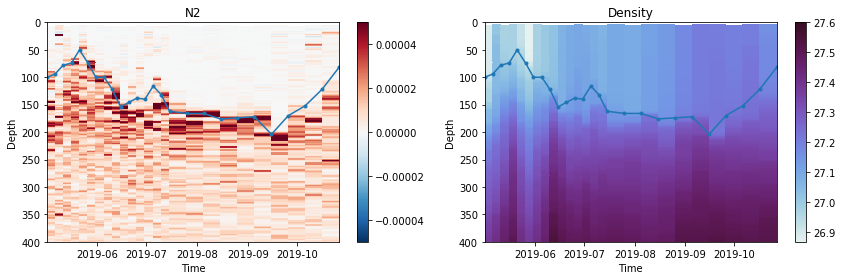

In [464]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.pcolormesh(ds_flt.JULD, ds_flt_int.Pressure, ds_flt_int.N2.T, 
               vmin=-5e-5, vmax=5e-5, cmap='RdBu_r')
plt.plot(ds_flt.JULD, ds_flt_int.MLD, Marker='.')

plt.gca().invert_yaxis()
plt.ylim([400, 0])
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Depth')
plt.title('N2')

plt.subplot(122)
plt.pcolormesh(ds_flt.JULD, ds_flt_int.Pressure, ds_flt_int.SIGMA0.T, 
                cmap=cmocean.cm.dense, vmax=27.6)
plt.plot(ds_flt.JULD, ds_flt_int.MLD, Marker='.')

plt.gca().invert_yaxis()
plt.ylim([400, 0])
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Depth')
plt.title('Density')

plt.tight_layout()

plt.savefig('../figures/12888_N2_dens.png')

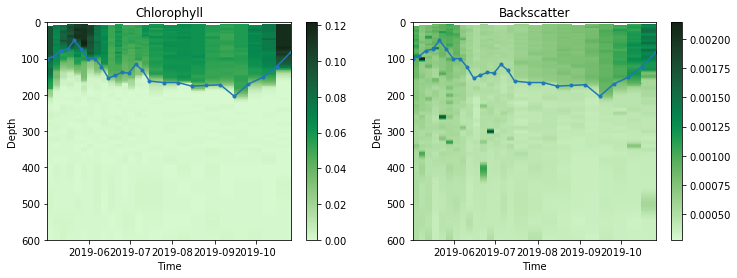

In [465]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.pcolormesh(ds_flt.JULD, ds_flt_int.Pressure, ds_flt_int.Chl_a_corr.T, 
               cmap=cmocean.cm.algae)
plt.plot(ds_flt.JULD, ds_flt_int.MLD, Marker='.')

plt.gca().invert_yaxis()
plt.ylim([600, 0])

plt.colorbar()

plt.xlabel('Time')
plt.ylabel('Depth')
plt.title('Chlorophyll')

plt.subplot(122)
plt.pcolormesh(ds_flt.JULD, ds_flt_int.Pressure, ds_flt_int.b_bp700.T, 
               cmap=cmocean.cm.algae)
plt.plot(ds_flt.JULD, ds_flt_int.MLD, Marker='.')

plt.gca().invert_yaxis()
plt.ylim([600, 0])

plt.colorbar()

plt.xlabel('Time')
plt.ylabel('Depth')
plt.title('Backscatter')

plt.savefig('../figures/12888_bio.png')

According to this document: https://ogsl.ca/sites/default/files/Unit_conversions_en_0.pdf 
we can convert $mmol/m^3$ to $ml/m^3$ by scaling up by 12.01 

Text(0.5, 1.0, 'POC (mg C $m^{-3}$)')

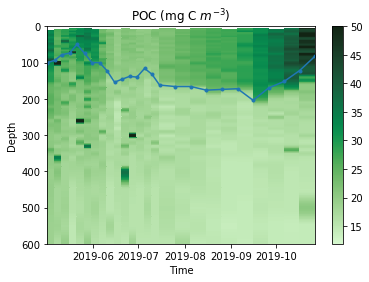

In [494]:
plt.pcolormesh(ds_flt.JULD, ds_flt_int.Pressure, 12.01*ds_flt_int.POC.T, 
               cmap=cmocean.cm.algae, vmax=50)
plt.plot(ds_flt.JULD, ds_flt_int.MLD, Marker='.')

plt.gca().invert_yaxis()
plt.ylim([600, 0])

plt.colorbar()

plt.xlabel('Time')
plt.ylabel('Depth')
plt.title(r'POC (mg C $m^{-3}$)')

(0.0008, 0.5)

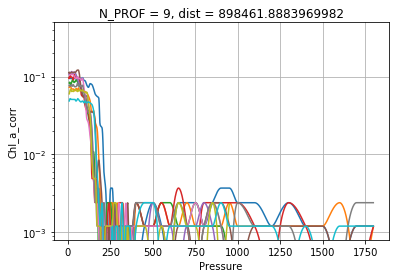

In [476]:
for i in range(10):
    ds_flt_int.Chl_a_corr.isel(N_PROF=i).plot()

plt.yscale('log')
plt.grid()
plt.ylim([8e-4 , 0.5])

In [496]:
temp = grid.cumsum(2*12.01*ds_flt_int.POC.where(ds_flt_int.Chl_a_corr>5e-3), 'Z', boundary='extend')

Text(0.5, 0, 'Time')

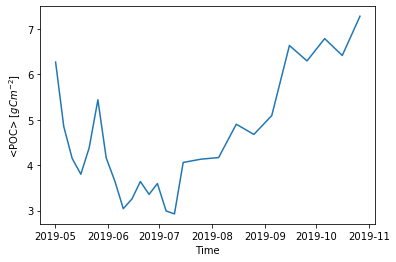

In [504]:
plt.plot( ds_flt.JULD, (temp/1000).isel(Pressure_left=-1),)
plt.ylabel('<POC> [$g C m^{-2}$]')
plt.xlabel('Time')


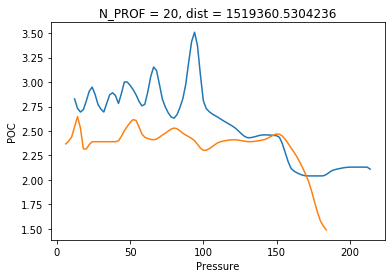

In [479]:
ds_flt_int.POC.where(ds_flt_int.Chl_a_corr>5e-3).isel(N_PROF=0).plot()
ds_flt_int.POC.where(ds_flt_int.Chl_a_corr>5e-3).isel(N_PROF=20).plot()

In [ ]:
# vertically integrated Chl and POC



Text(0.5, 1.0, 'Oxygen')

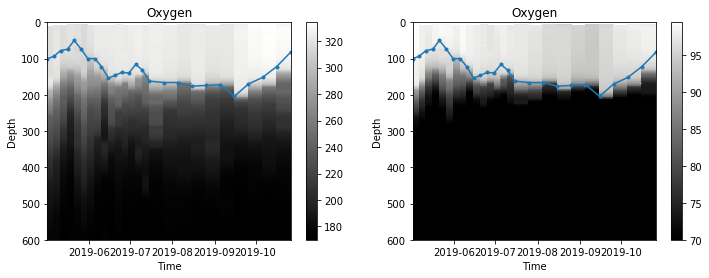

In [462]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.pcolormesh(ds_flt.JULD, ds_flt_int.Pressure, ds_flt_int.Oxygen.T, 
               cmap=cmocean.cm.gray)
plt.plot(ds_flt.JULD, ds_flt_int.MLD, Marker='.')

plt.gca().invert_yaxis()
plt.ylim([600, 0])

plt.colorbar()

plt.xlabel('Time')
plt.ylabel('Depth')
plt.title('Oxygen')

plt.subplot(122)
plt.pcolormesh(ds_flt.JULD, ds_flt_int.Pressure, ds_flt_int.OxygenSat.T, 
               cmap=cmocean.cm.gray, vmin=70)
plt.plot(ds_flt.JULD, ds_flt_int.MLD, Marker='.')

plt.gca().invert_yaxis()
plt.ylim([600, 0])

plt.colorbar()

plt.xlabel('Time')
plt.ylabel('Depth')
plt.title('Oxygen')

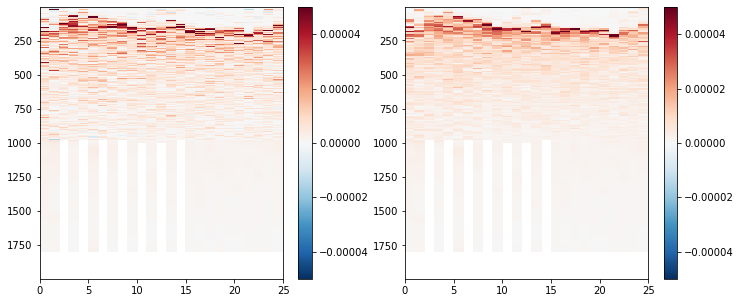

In [278]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.pcolormesh(temp, Pmid, N2.T, cmap="RdBu_r", vmin=-5e-5, vmax=5e-5)
plt.plot(MLD.N_PROF)
plt.gca().invert_yaxis()
plt.colorbar()

plt.subplot(122)
plt.pcolormesh(temp, Pmid_sm, N2_sm.T, cmap="RdBu_r", vmin=-5e-5, vmax=5e-5)
plt.gca().invert_yaxis()
plt.colorbar()

(500, 0)

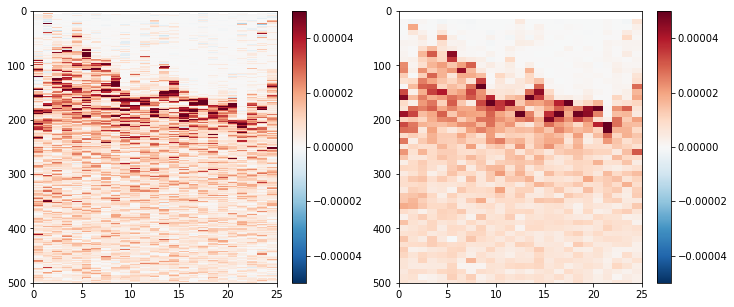

In [279]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.pcolormesh(temp, Pmid, N2.T, cmap="RdBu_r", vmin=-5e-5, vmax=5e-5)
plt.gca().invert_yaxis()
plt.colorbar()
plt.ylim([500, 0])

plt.subplot(122)
plt.pcolormesh(temp, Pmid_sm, N2_sm.T, cmap="RdBu_r", vmin=-5e-5, vmax=5e-5)
plt.gca().invert_yaxis()
plt.colorbar()
plt.ylim([500, 0])

(500, 0)

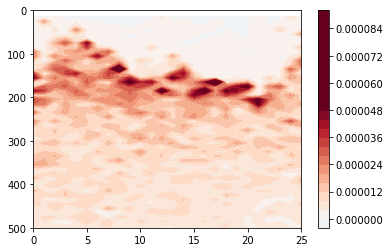

In [372]:
plt.contourf(temp, Pmid_sm, N2_sm.T, cmap="RdBu_r", vmin=-5e-5, vmax=5e-5, levels=22)
plt.gca().invert_yaxis()
plt.colorbar()
plt.ylim([500, 0])

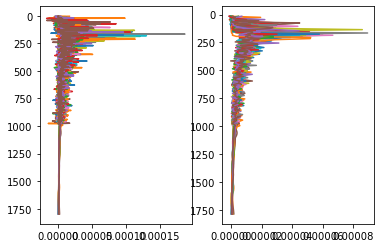

In [280]:
plt.subplot(121)
plt.plot(N2.T, Pmid)
plt.gca().invert_yaxis()

plt.subplot(122)
plt.plot(N2_sm.T, Pmid_sm)
plt.gca().invert_yaxis()

In [146]:
g = 9.81
rho0 = 1000

In [147]:
N2 = g / rho0 * ds_flt.SIGMA0.diff("N_LEVELS") / ds_flt.Pressure.diff("N_LEVELS")

In [153]:
N2

<xarray.DataArray (N_PROF: 26, N_LEVELS: 557)>
array([[ 5.31609674e-07,  4.68777399e-07,  1.20825508e-06, ...,
                    nan,             nan,             nan],
       [ 9.33763494e-07,  7.81599965e-07,  1.40194841e-06, ...,
                    nan,             nan,             nan],
       [ 9.02780239e-07,  2.51132744e-06,  2.45955267e-06, ...,
                    nan,             nan,             nan],
       ...,
       [ 5.22881960e-07,  5.85588880e-07,  6.90802106e-07, ...,
        -3.88321878e-07,             nan,             nan],
       [ 3.26169839e-07,  3.64736690e-07,  8.25876966e-07, ...,
         4.64915051e-07,             nan,             nan],
       [ 2.72716120e-07,  4.84874824e-07,  6.32117977e-07, ...,
                    nan,             nan,             nan]])
Coordinates:
    pressure  (N_PROF, N_LEVELS) float64 1.699e+03 1.599e+03 ... nan nan
Dimensions without coordinates: N_PROF, N_LEVELS

In [157]:
dens_roll = ds_flt.SIGMA0.rolling(N_LEVELS=10, center=True).mean()
N2_sm = g / rho0 * dens_roll.diff("N_LEVELS") / ds_flt.Pressure.diff("N_LEVELS")

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [158]:
Pmid = 0.5 * (ds_flt.Pressure[:, 0:-1] + ds_flt.Pressure[:, 1:])

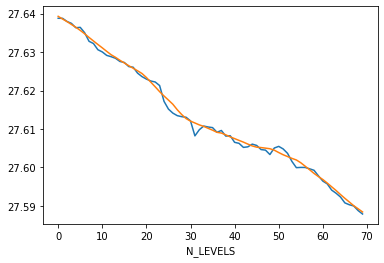

In [162]:
ds_flt.SIGMA0.isel(N_PROF=0).sel(N_LEVELS=slice(70, 140)).plot()
dens_roll.isel(N_PROF=0).sel(N_LEVELS=slice(70, 140)).plot()

In [166]:
ds_flt.Pressure.isel(N_PROF=0).sel(N_LEVELS=slice(70, 140)).values

array([860.  , 858.  , 856.  , 854.  , 852.  , 851.5 , 850.  , 848.  ,
       846.  , 844.  , 842.  , 840.  , 838.  , 836.  , 834.  , 832.  ,
       830.  , 828.  , 826.  , 824.  , 822.  , 820.  , 818.  , 816.  ,
       814.  , 812.  , 810.  , 807.9 , 806.  , 804.  , 802.  , 801.41,
       800.  , 798.  , 796.  , 794.  , 792.  , 790.  , 788.  , 786.  ,
       784.  , 782.  , 780.  , 778.  , 776.  , 774.  , 772.  , 770.  ,
       768.  , 766.  , 764.  , 762.  , 760.  , 758.  , 756.  , 754.  ,
       752.  , 751.52, 750.  , 748.  , 746.  , 744.  , 742.  , 740.  ,
       738.  , 736.  , 734.  , 732.  , 730.  , 728.  ])

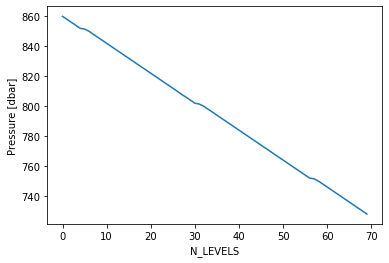

In [165]:
ds_flt.Pressure.isel(N_PROF=0).sel(N_LEVELS=slice(70, 140)).plot()

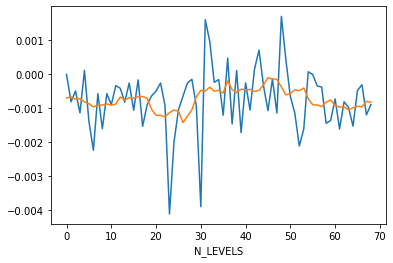

In [164]:
ds_flt.SIGMA0.isel(N_PROF=0).sel(N_LEVELS=slice(70, 140)).diff("N_LEVELS").plot()
dens_roll.isel(N_PROF=0).sel(N_LEVELS=slice(70, 140)).diff("N_LEVELS").plot()

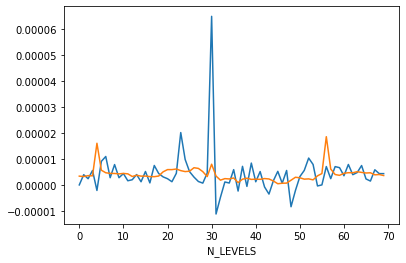

In [161]:
N2.isel(N_PROF=0).sel(N_LEVELS=slice(70, 140)).plot()
N2_sm.isel(N_PROF=0).sel(N_LEVELS=slice(70, 140)).plot()

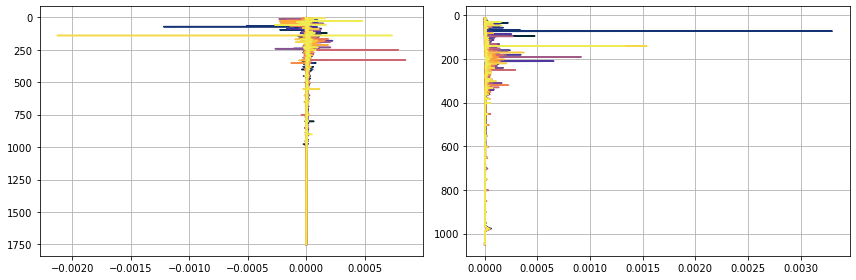

In [263]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
for i in range(ncasts):
    plt.plot(
        N2.isel(N_PROF=i), Pmid.isel(N_PROF=i), color=cmocean.cm.thermal(i / ncasts)
    )
plt.gca().invert_yaxis()
plt.grid()

plt.subplot(122)
for i in range(ncasts):
    plt.plot(
        N2_sm.isel(N_PROF=i), Pmid.isel(N_PROF=i), color=cmocean.cm.thermal(i / ncasts)
    )
plt.gca().invert_yaxis()
plt.grid()
plt.tight_layout()

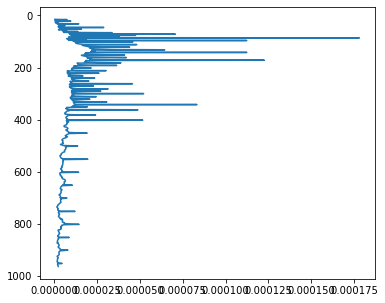

In [264]:
plt.figure(figsize=(6, 5))
plt.plot(N2_sm.isel(N_PROF=2), Pmid.isel(N_PROF=2))
plt.gca().invert_yaxis()

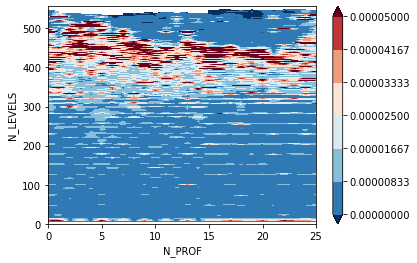

In [267]:
N2_sm.T.plot.contourf(vmin=0, vmax=5e-5, cmap="RdBu_r")

In [268]:
Numgrid2 = np.tile(ds_flt.N_PROF, (557, 1))

In [1]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.scatter(Numgrid2.T, Z, s=20, c=N2, cmap="RdBu_r", vmin=0, vmax=5e-5)
plt.colorbar(orientation="horizontal", fraction=0.03)
plt.ylim([0, 1000])
plt.gca().invert_yaxis()
plt.xlabel("Profile #")
plt.ylabel("Depth")
plt.title("N2")

plt.subplot(122)
plt.scatter(Numgrid2.T, Z, s=20, c=N2_sm, cmap="RdBu_r", vmin=0, vmax=5e-5)
plt.colorbar(orientation="horizontal", fraction=0.03)
plt.ylim([0, 1000])
plt.gca().invert_yaxis()
plt.xlabel("Profile #")
plt.ylabel("Depth")
plt.title("N2 smoothened")

NameError: name 'plt' is not defined

## 12880 

This float was released a bit south but also on I06

In [29]:
ds_flt = float_dic_HR[12880]

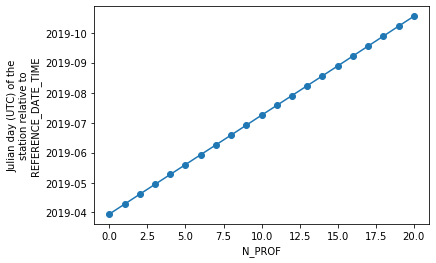

In [31]:
ds_flt.JULD.plot(Marker="o")
# the faster sampling is visible for the first 15 profiles.

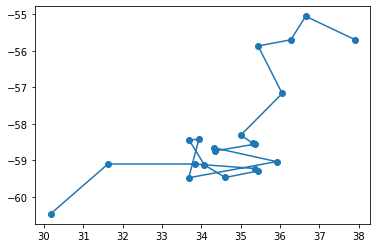

In [32]:
plt.plot(ds_flt.Lon, ds_flt.Lat, Marker="o")

In [33]:
dist = gsw.distance(ds_flt.Lon, ds_flt.Lat)
distance = np.cumsum(dist)
distance = np.insert(distance, 0, 0)
ds_flt["distance"] = distance

In [34]:
Numgrid = np.tile(ds_flt.N_PROF, (558, 1))
Numgrid.shape

(558, 21)

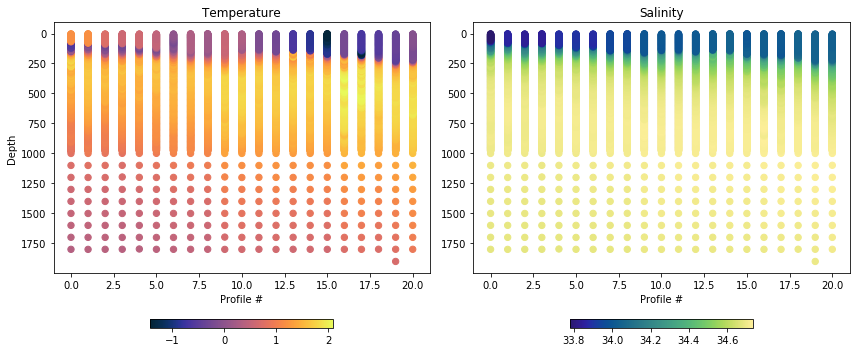

In [35]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.scatter(
    Numgrid.T, ds_flt.Pressure, s=40, c=ds_flt.Temperature, cmap=cmocean.cm.thermal
)
plt.colorbar(orientation="horizontal", fraction=0.03)
plt.gca().invert_yaxis()
plt.xlabel("Profile #")
plt.ylabel("Depth")
plt.title("Temperature")

plt.subplot(122)
plt.scatter(Numgrid.T, ds_flt.Pressure, s=40, c=ds_flt.Salinity, cmap=cmocean.cm.haline)
plt.colorbar(orientation="horizontal", fraction=0.03)
plt.gca().invert_yaxis()
plt.xlabel("Profile #")
plt.title("Salinity")
plt.tight_layout()

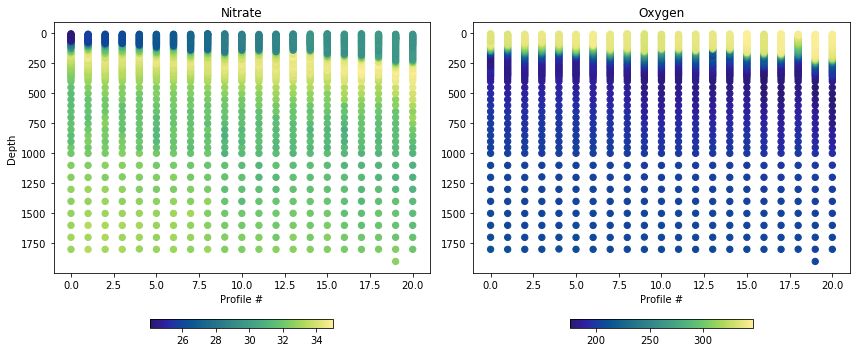

In [36]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.scatter(Numgrid.T, ds_flt.Pressure, s=40, c=ds_flt.Nitrate, cmap=cmocean.cm.haline)
plt.colorbar(orientation="horizontal", fraction=0.03)
plt.gca().invert_yaxis()
plt.xlabel("Profile #")
plt.ylabel("Depth")
plt.title("Nitrate")

plt.subplot(122)
plt.scatter(Numgrid.T, ds_flt.Pressure, s=40, c=ds_flt.Oxygen, cmap=cmocean.cm.haline)
plt.colorbar(orientation="horizontal", fraction=0.03)
plt.gca().invert_yaxis()
plt.xlabel("Profile #")
# plt.ylabel('Depth')
plt.title("Oxygen")
plt.tight_layout()

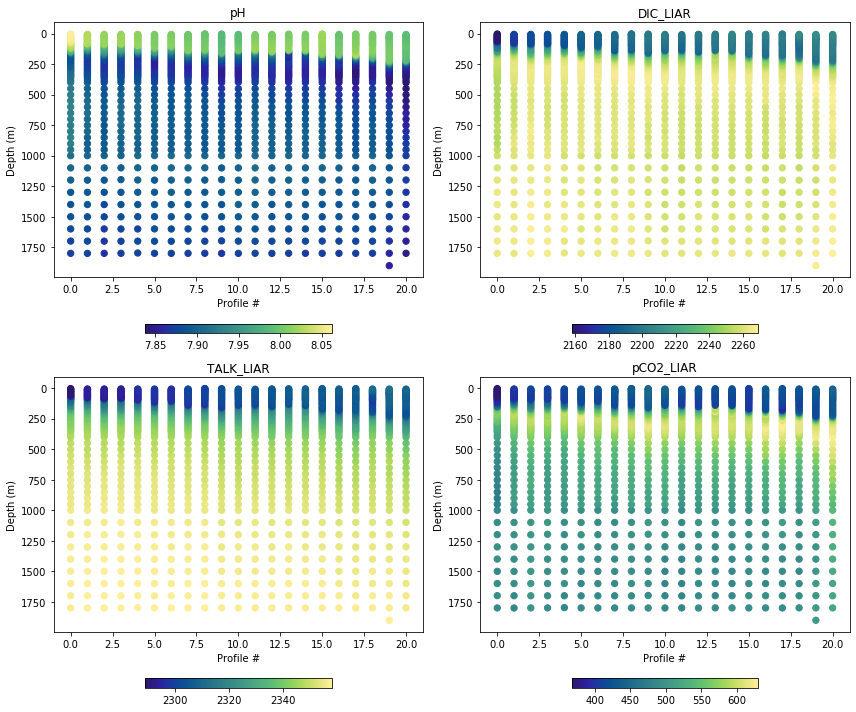

In [37]:
plt.figure(figsize=(12, 10))

plt.subplot(221)
plt.scatter(Numgrid.T, ds_flt.Pressure, s=40, c=ds_flt.pHinsitu, cmap=cmocean.cm.haline)
plt.colorbar(orientation="horizontal", fraction=0.03)
plt.gca().invert_yaxis()
plt.xlabel("Profile #")
plt.ylabel("Depth (m)")
plt.title("pH")

plt.subplot(222)
plt.scatter(Numgrid.T, ds_flt.Pressure, s=40, c=ds_flt.DIC_LIAR, cmap=cmocean.cm.haline)
plt.colorbar(orientation="horizontal", fraction=0.03)
plt.gca().invert_yaxis()
plt.xlabel("Profile #")
plt.ylabel("Depth (m)")
plt.title("DIC_LIAR")

plt.subplot(223)
plt.scatter(
    Numgrid.T, ds_flt.Pressure, s=40, c=ds_flt.TALK_LIAR, cmap=cmocean.cm.haline
)
plt.colorbar(orientation="horizontal", fraction=0.03)
plt.gca().invert_yaxis()
plt.xlabel("Profile #")
plt.ylabel("Depth (m)")
plt.title("TALK_LIAR")

plt.subplot(224)
plt.scatter(
    Numgrid.T, ds_flt.Pressure, s=40, c=ds_flt.pCO2_LIAR, cmap=cmocean.cm.haline
)
plt.colorbar(orientation="horizontal", fraction=0.03)
plt.gca().invert_yaxis()
plt.xlabel("Profile #")
plt.ylabel("Depth (m)")
plt.title("pCO2_LIAR")

plt.tight_layout()
plt.savefig("../figures/carbon_variables.png")